----

### **GPMIntro.ipynb**
Copyright (C) &lsaquo; 2017 &rsaquo;  &lsaquo; Anna Scaife - anna.scaife@manchester.ac.uk &rsaquo;

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

----

**[AMS - 170402]** Notebook created for **SKA-SA Newton Big Data Summer School, Cape Town , April 2017**<br>
**[AMS - 170823]**  Notebook updated for **TIARA Astrostatistics Summer School, Taipei, August 2017**<br>
**[AMS - 180528]**  Notebook updated for **JEDI Madagascar, Nosy Be, May 2018**<br>
**[AMS - 190910]**  Notebook updated for **CERN School of Computing, Cluj-Napoca, Sept 2019**<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*This version has significant syntax changes due to the update from george==0.2.1 to george==0.3.1*



This notebook uses GPM to forward predict a signal. It follows the example given in Rasmussen & Williams (http://www.gaussianprocess.org/gpml/chapters/) and optimizes covariance kernel hyper-parameters to predict the CO$_{2}$ concentration on Mauna Loa.  It is a teaching resource and is accompanied by the lecture "Can You Predict the Future..?"

---------------------------------------------------------------------------------------------

To start let's specify that we want our figures to appear embedded in the notebook:

In [1]:
%matplotlib inline

Then let's import all the libraries we need...

In [2]:
import numpy as np
import george
from george import kernels
import statsmodels.api as sm
import scipy.optimize as op
import pylab as pl

Some code to control the size of figures in the notebook:

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

First grab the data:

In [4]:
# this is a function to read the Mauna Loa data from file
def read_co2(filename):
    
    co2file = open(filename,'r')
    
    time=[];co2=[]
    while True:
        line = co2file.readline()
        if not line: break
    
        items = line.split()
        
        if (items[0]!='#') and (items[3]!='-99.99'):
            
            time.append(float(items[2]))
            co2.append(float(items[3]))
            
    time=np.array(time)
    co2=np.array(co2)
    
    return time,co2

t,y = read_co2("./data/mauna_loa.dat")

Let's take a look at the data:

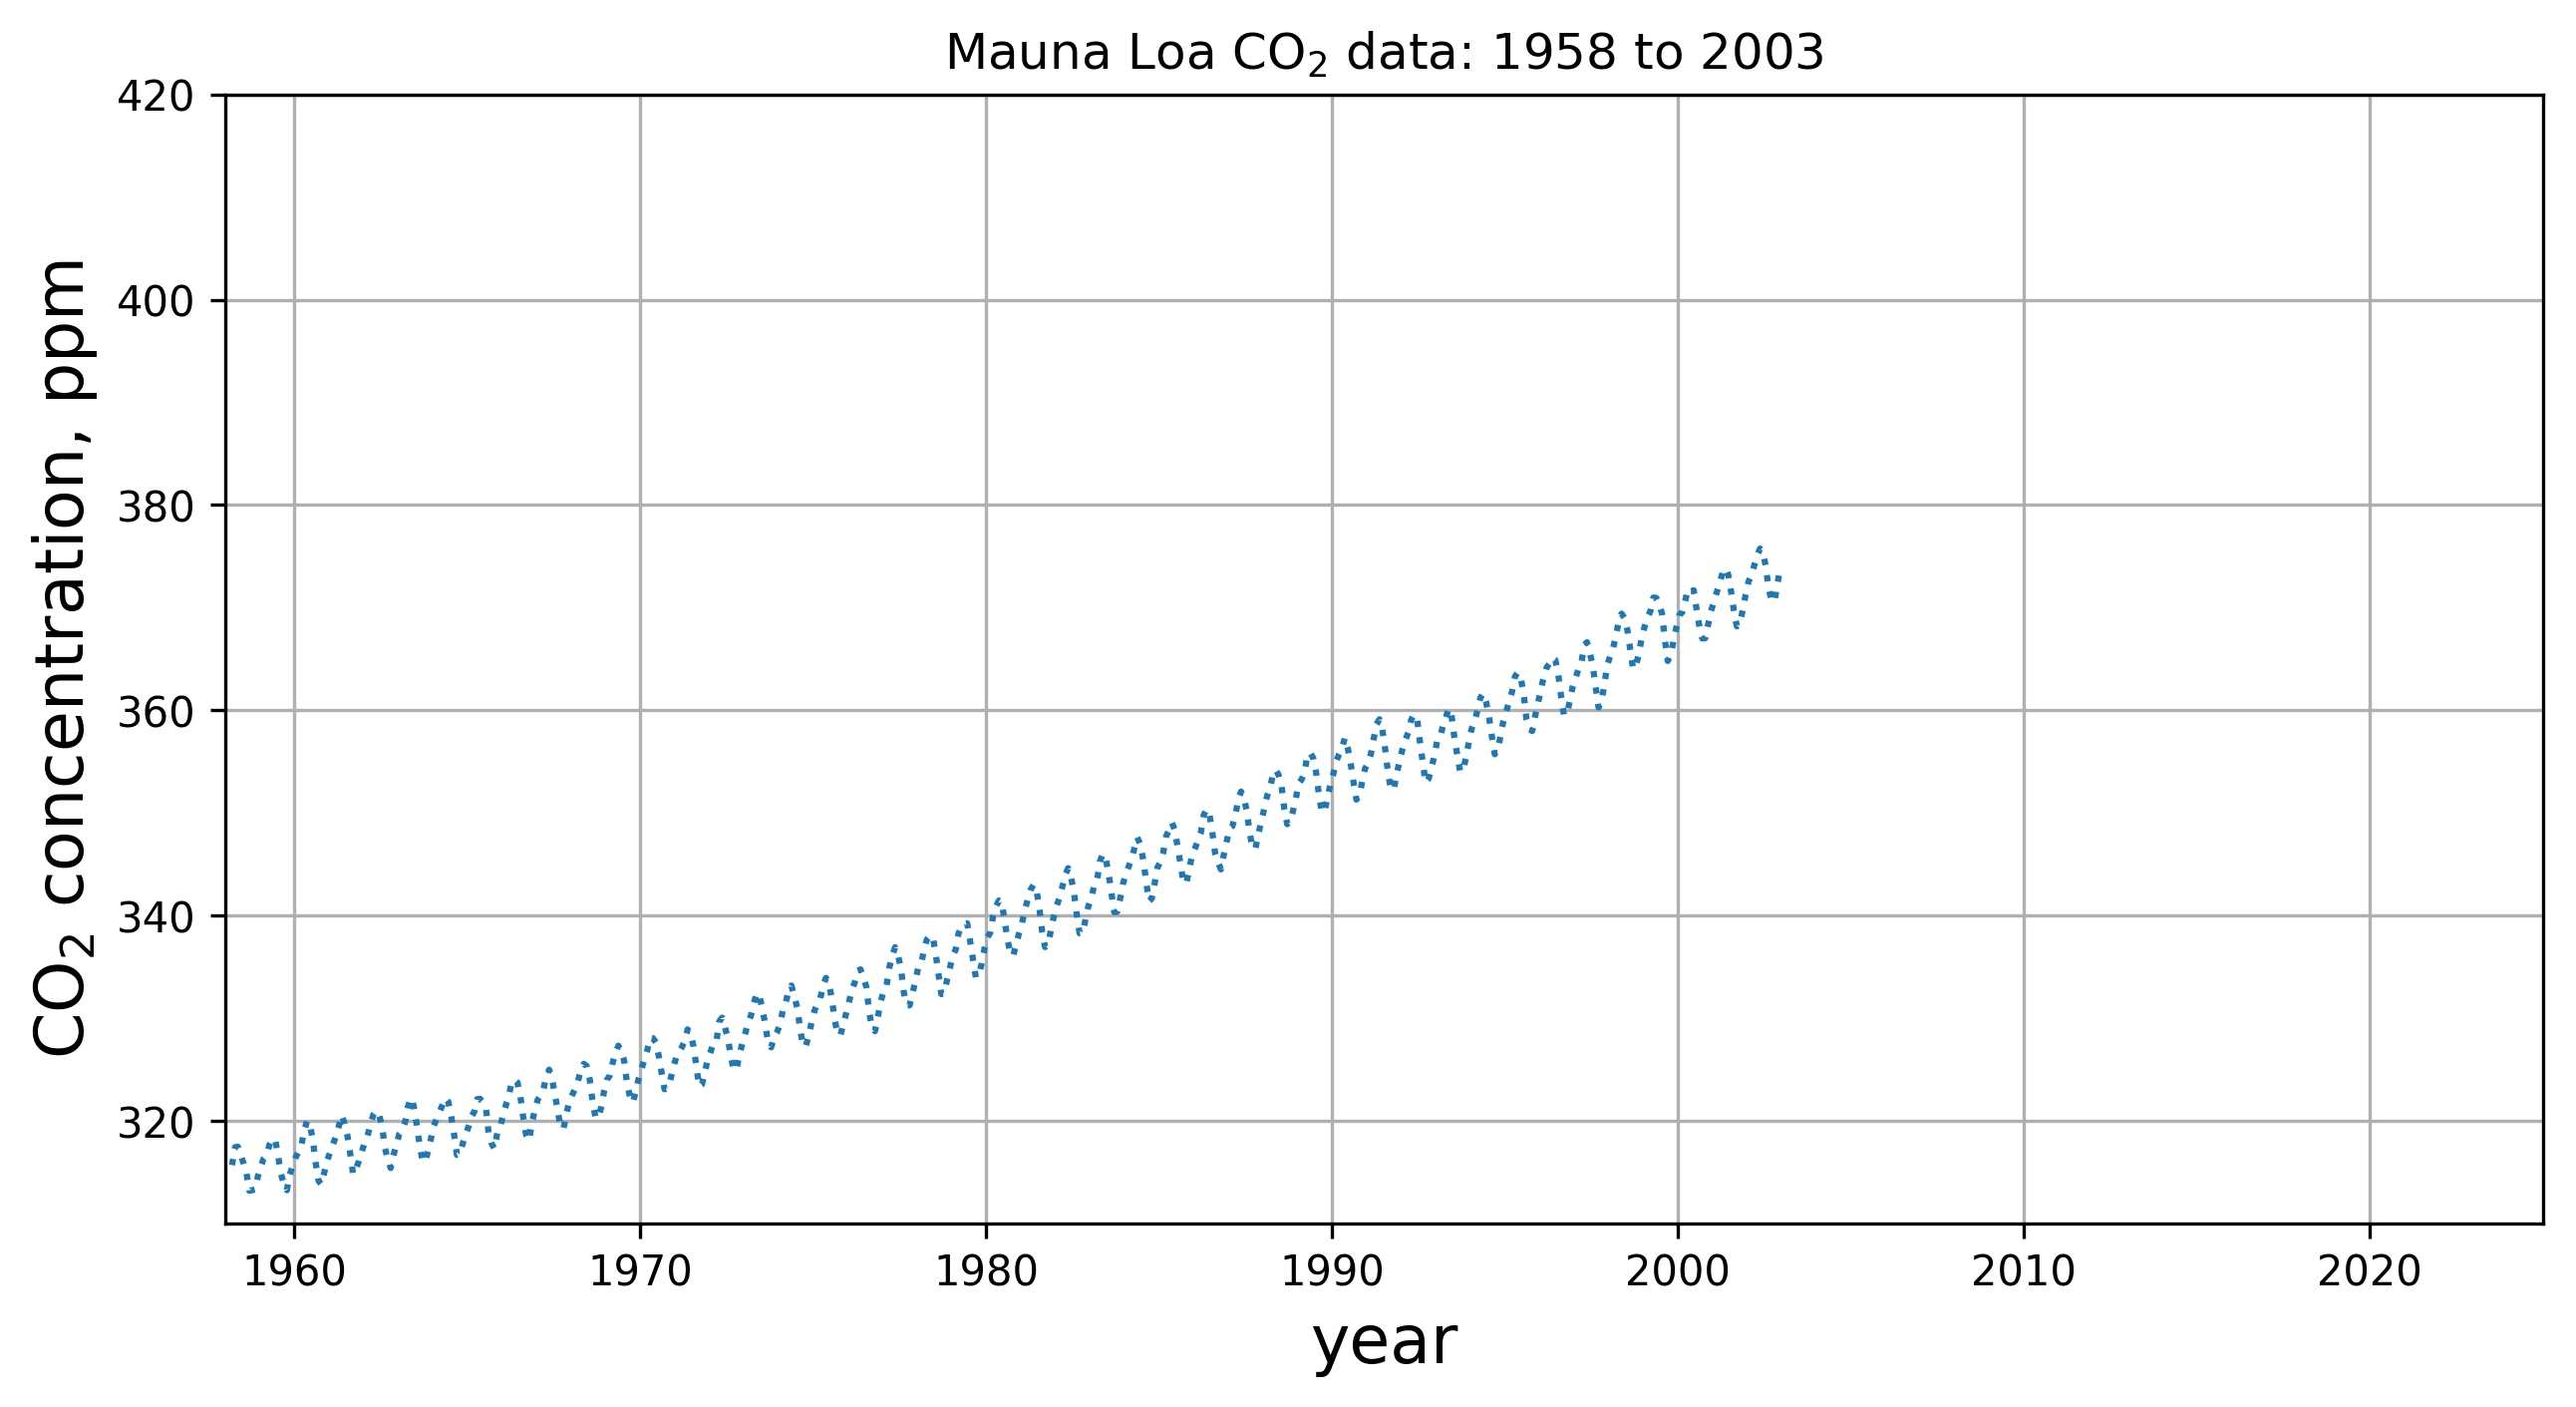

In [5]:
pl.subplot(111)
pl.plot(t[np.where(t<2003.)],y[np.where(t<2003.)],ls=':')
pl.ylabel(r"CO$_2$ concentration, ppm", fontsize=16)
pl.xlabel("year", fontsize=16)
pl.title(r"Mauna Loa CO$_2$ data: 1958 to 2003")
pl.axis([1958.,2025.,310.,420.])
pl.grid()
pl.show()

Let's split out the data up to 2003:

In [6]:
y_to_2003 = y[np.where(t<2003.)]
t_to_2003 = t[np.where(t<2003.)]

Set up the various covariance kernels. These are given by [Eq. 5.15 - 5.18 in RW](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf). Note that we've given each of these kernels arguments. These will act as our initial guess at parameter values.

In [7]:
k1 = 66.0**2 * kernels.ExpSquaredKernel(metric=67**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(gamma=2/1.3**2, log_period=0.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(log_alpha=np.log(0.78), metric=1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2)

Then we sum them to make the combined kernel ([Eq. 5.19 in RW](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf)).

In [8]:
kernel = k1 + k2 + k3 + k4

We then feed this kernel to the george library.

In [9]:
gp = george.GP(kernel, mean=np.mean(y_to_2003), fit_mean=True, white_noise=np.log(0.19**2), fit_white_noise=True)

We can immediately compute the covariance matrix because we've entered some initial guess parameters as the arguments in our kernels.

In [10]:
gp.compute(t_to_2003)

Then we can immediately calculate our prediction out to 2025...

In [11]:
# range of times for prediction:
x = np.linspace(max(t_to_2003), 2025, 2000)

# calculate expectation and variance at each point:
mu, cov = gp.predict(y_to_2003, x, return_var=True)
#std = np.sqrt(np.diag(cov))
std = np.sqrt(cov)

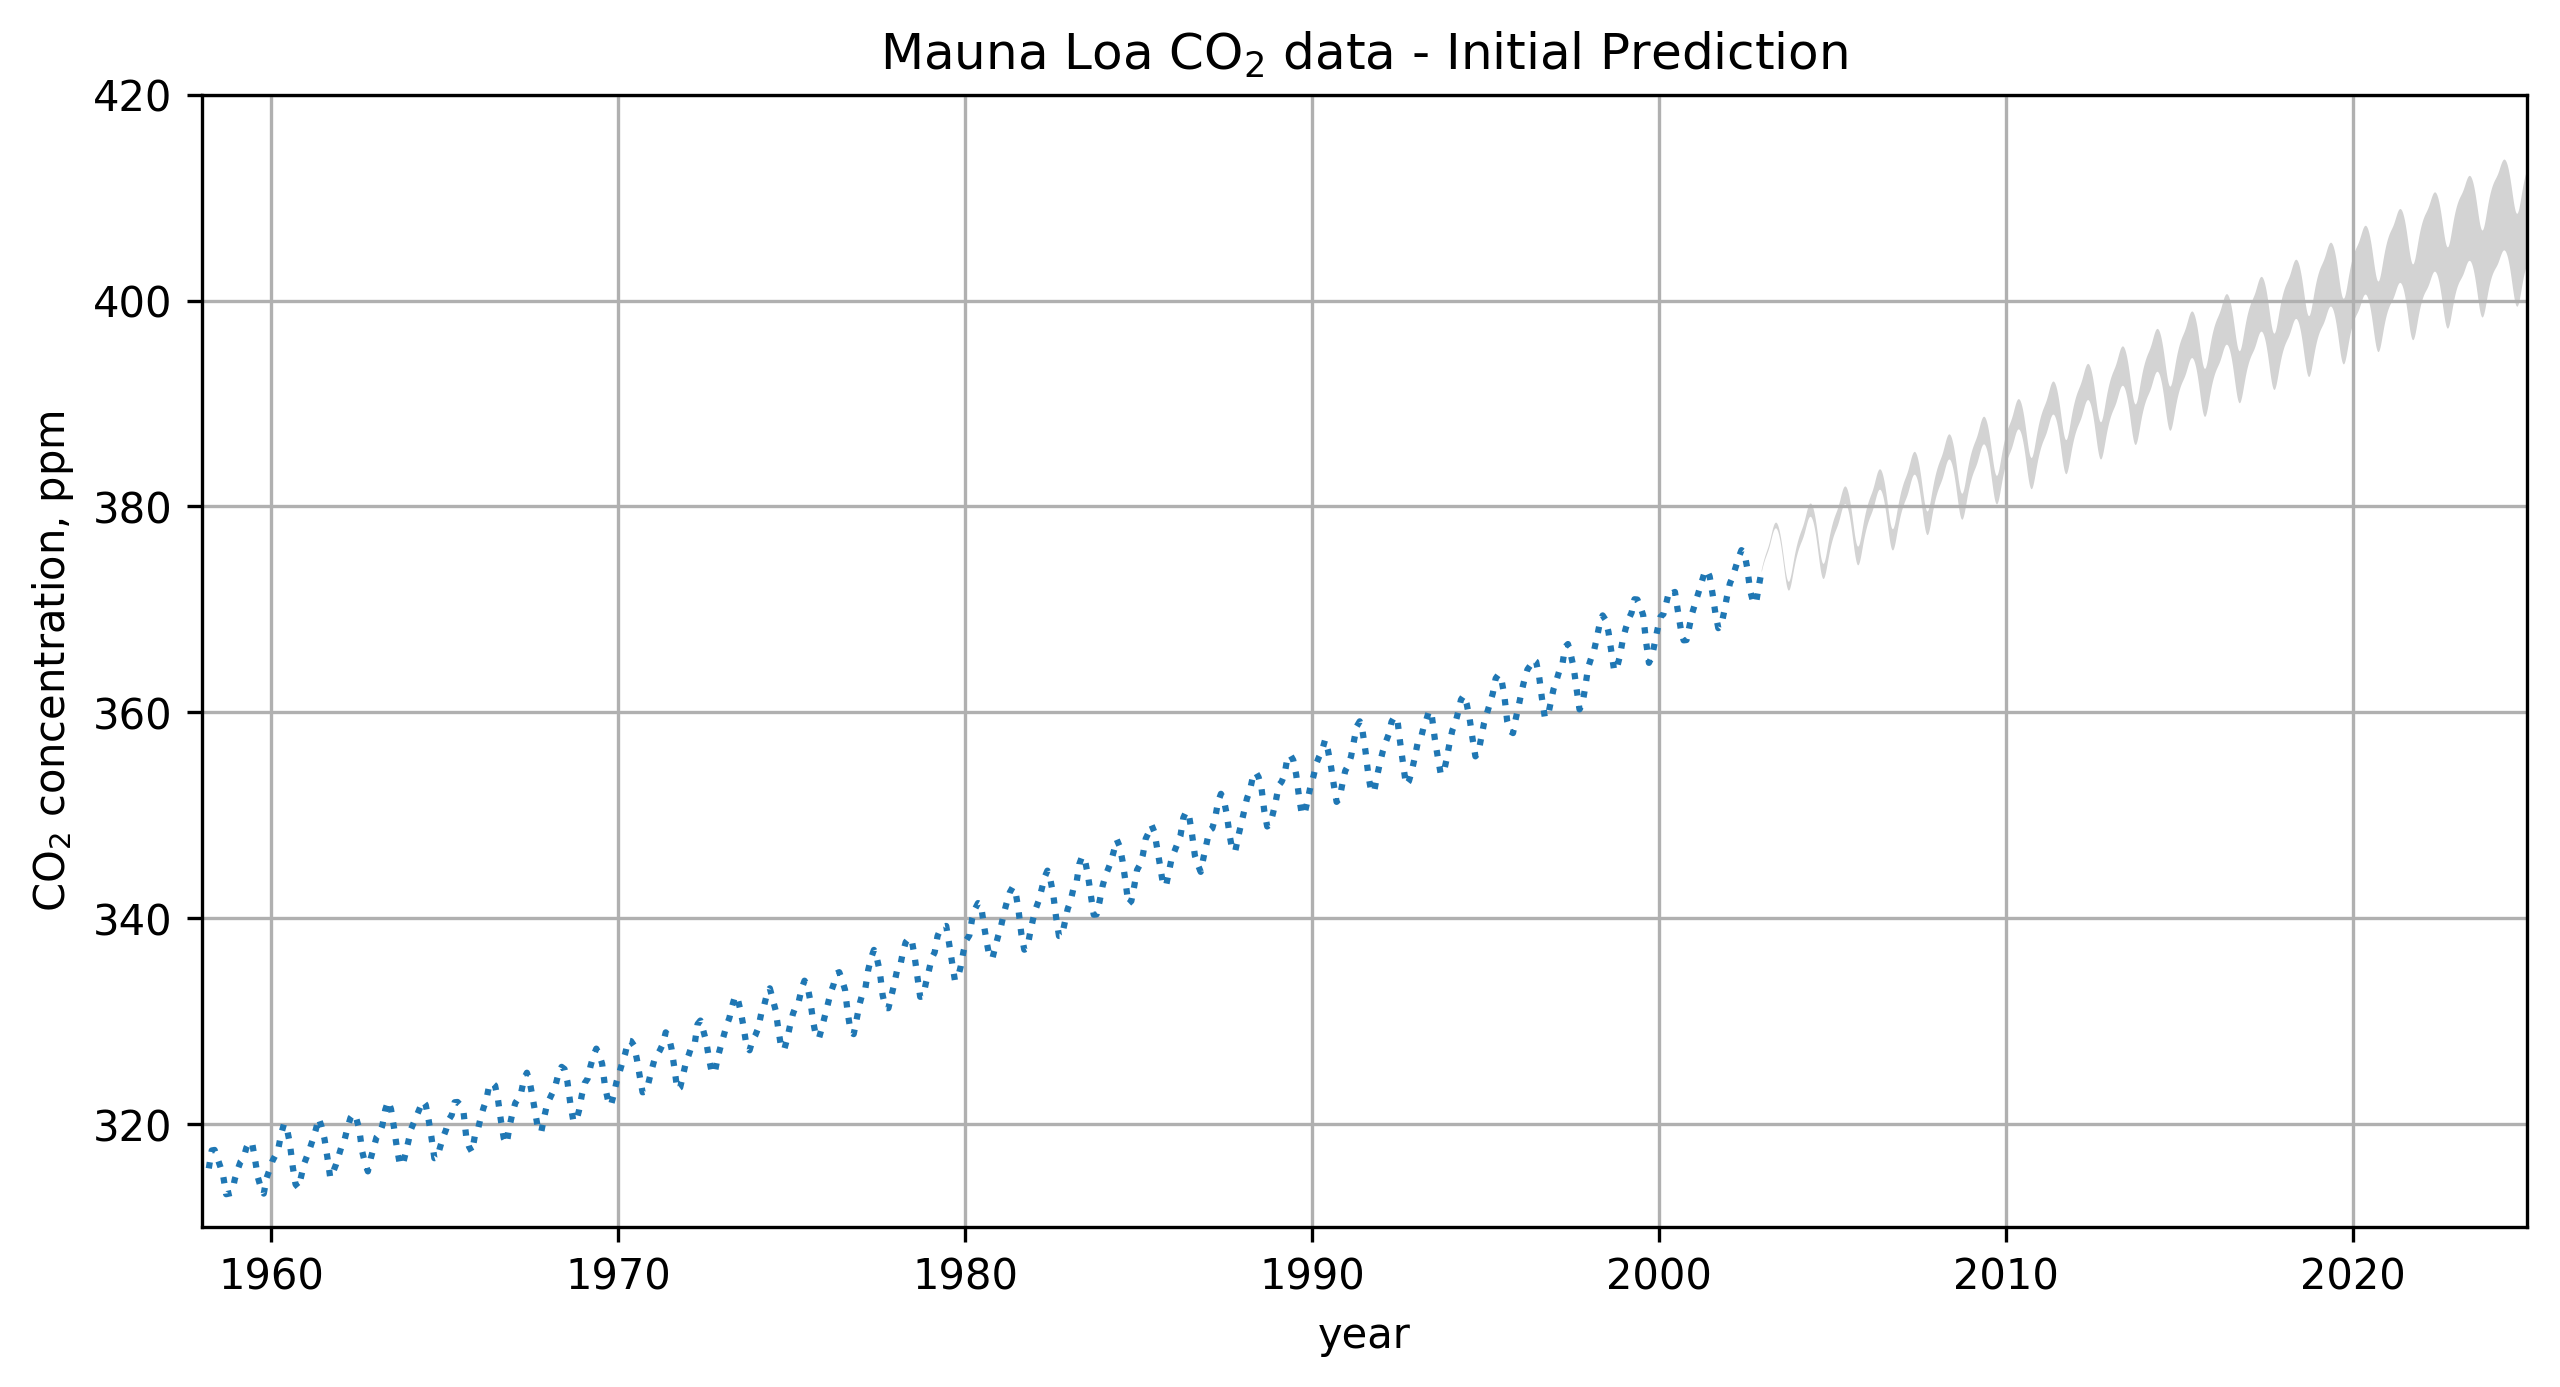

In [12]:
ax = pl.subplot(111)

# plot the original values
pl.plot(t_to_2003,y_to_2003,ls=':') 

# shade in the area inside a one standard deviation bound:
ax.fill_between(x,mu-std,mu+std,facecolor='lightgrey', lw=0, interpolate=True)

pl.ylabel(r"CO$_2$ concentration, ppm")
pl.xlabel("year")
pl.title(r"Mauna Loa CO$_2$ data - Initial Prediction")
pl.axis([1958.,2025.,310.,420.])
pl.grid()

# display the figure:
pl.show()

To use the scipy library optimization function we need to provide (1) an objective function to optimize and (2) the *gradient* of that function. 

Here we define the objective function for the optimization as a negative log-likelihood. We could write this function ourselves, but in fact george has a built in log-likelihood that we can simply call directly.

The log-likelihood is computed as

$$(\mathbf{y} - X^T \mathbf{x})^T C^{-1}(\mathbf{y} - X^T \mathbf{x}) $$

where $y$ is the variable and $x$ are the points at which it is measured; $C$ is the covariance matrix and $X$ is the operator that maps $x$ onto $y$.

In [13]:
# -----------------------------------------------------------------

def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(y_to_2003, quiet=True)
    
    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# -----------------------------------------------------------------

And the gradient of the objective function:

In [14]:
# -----------------------------------------------------------------

def grad_nll(p):
    # Update the kernel parameters and compute the likelihood gradient.
    gp.set_parameter_vector(p)
    gll = gp.grad_lnlikelihood(y_to_2003, quiet=True)
    return -gll

# -----------------------------------------------------------------

You need to compute the GP once before starting the optimization. We've actually already done this above, but it doesn't hurt to run it again.

In [15]:
gp.compute(t_to_2003)

Then run the optimization routine:

In [16]:
# initial guess at parameters (see above):
p0 = gp.get_parameter_vector()

# if you want to view your initial guess values uncomment the line below
#print(p0)

# run optimization:
results = op.minimize(nll, p0, jac=grad_nll)

print(np.exp(results.x))

[3.83187655e+161 3.53549456e-002 2.74473399e+003 3.55667406e+003
 6.68407829e+000 9.00974562e+003 2.40760445e+000 9.99559981e-001
 1.06675046e+001 1.38637903e-003 2.52367892e+000 2.48461983e-001
 1.12125665e+000]


Update the kernel with the results of the optimization:

In [17]:
gp.set_parameter_vector(results.x)

Then use this kernel to calculate the predicted expectation value and variance of the data over a range of times:

In [18]:
# range of times for prediction:
x = np.linspace(max(t_to_2003), 2025, 2000)

# calculate expectation and variance at each point:
mu, cov = gp.predict(y_to_2003, x, return_var=True)
std = np.sqrt(cov)

Now let's plot the optimised  prediction...

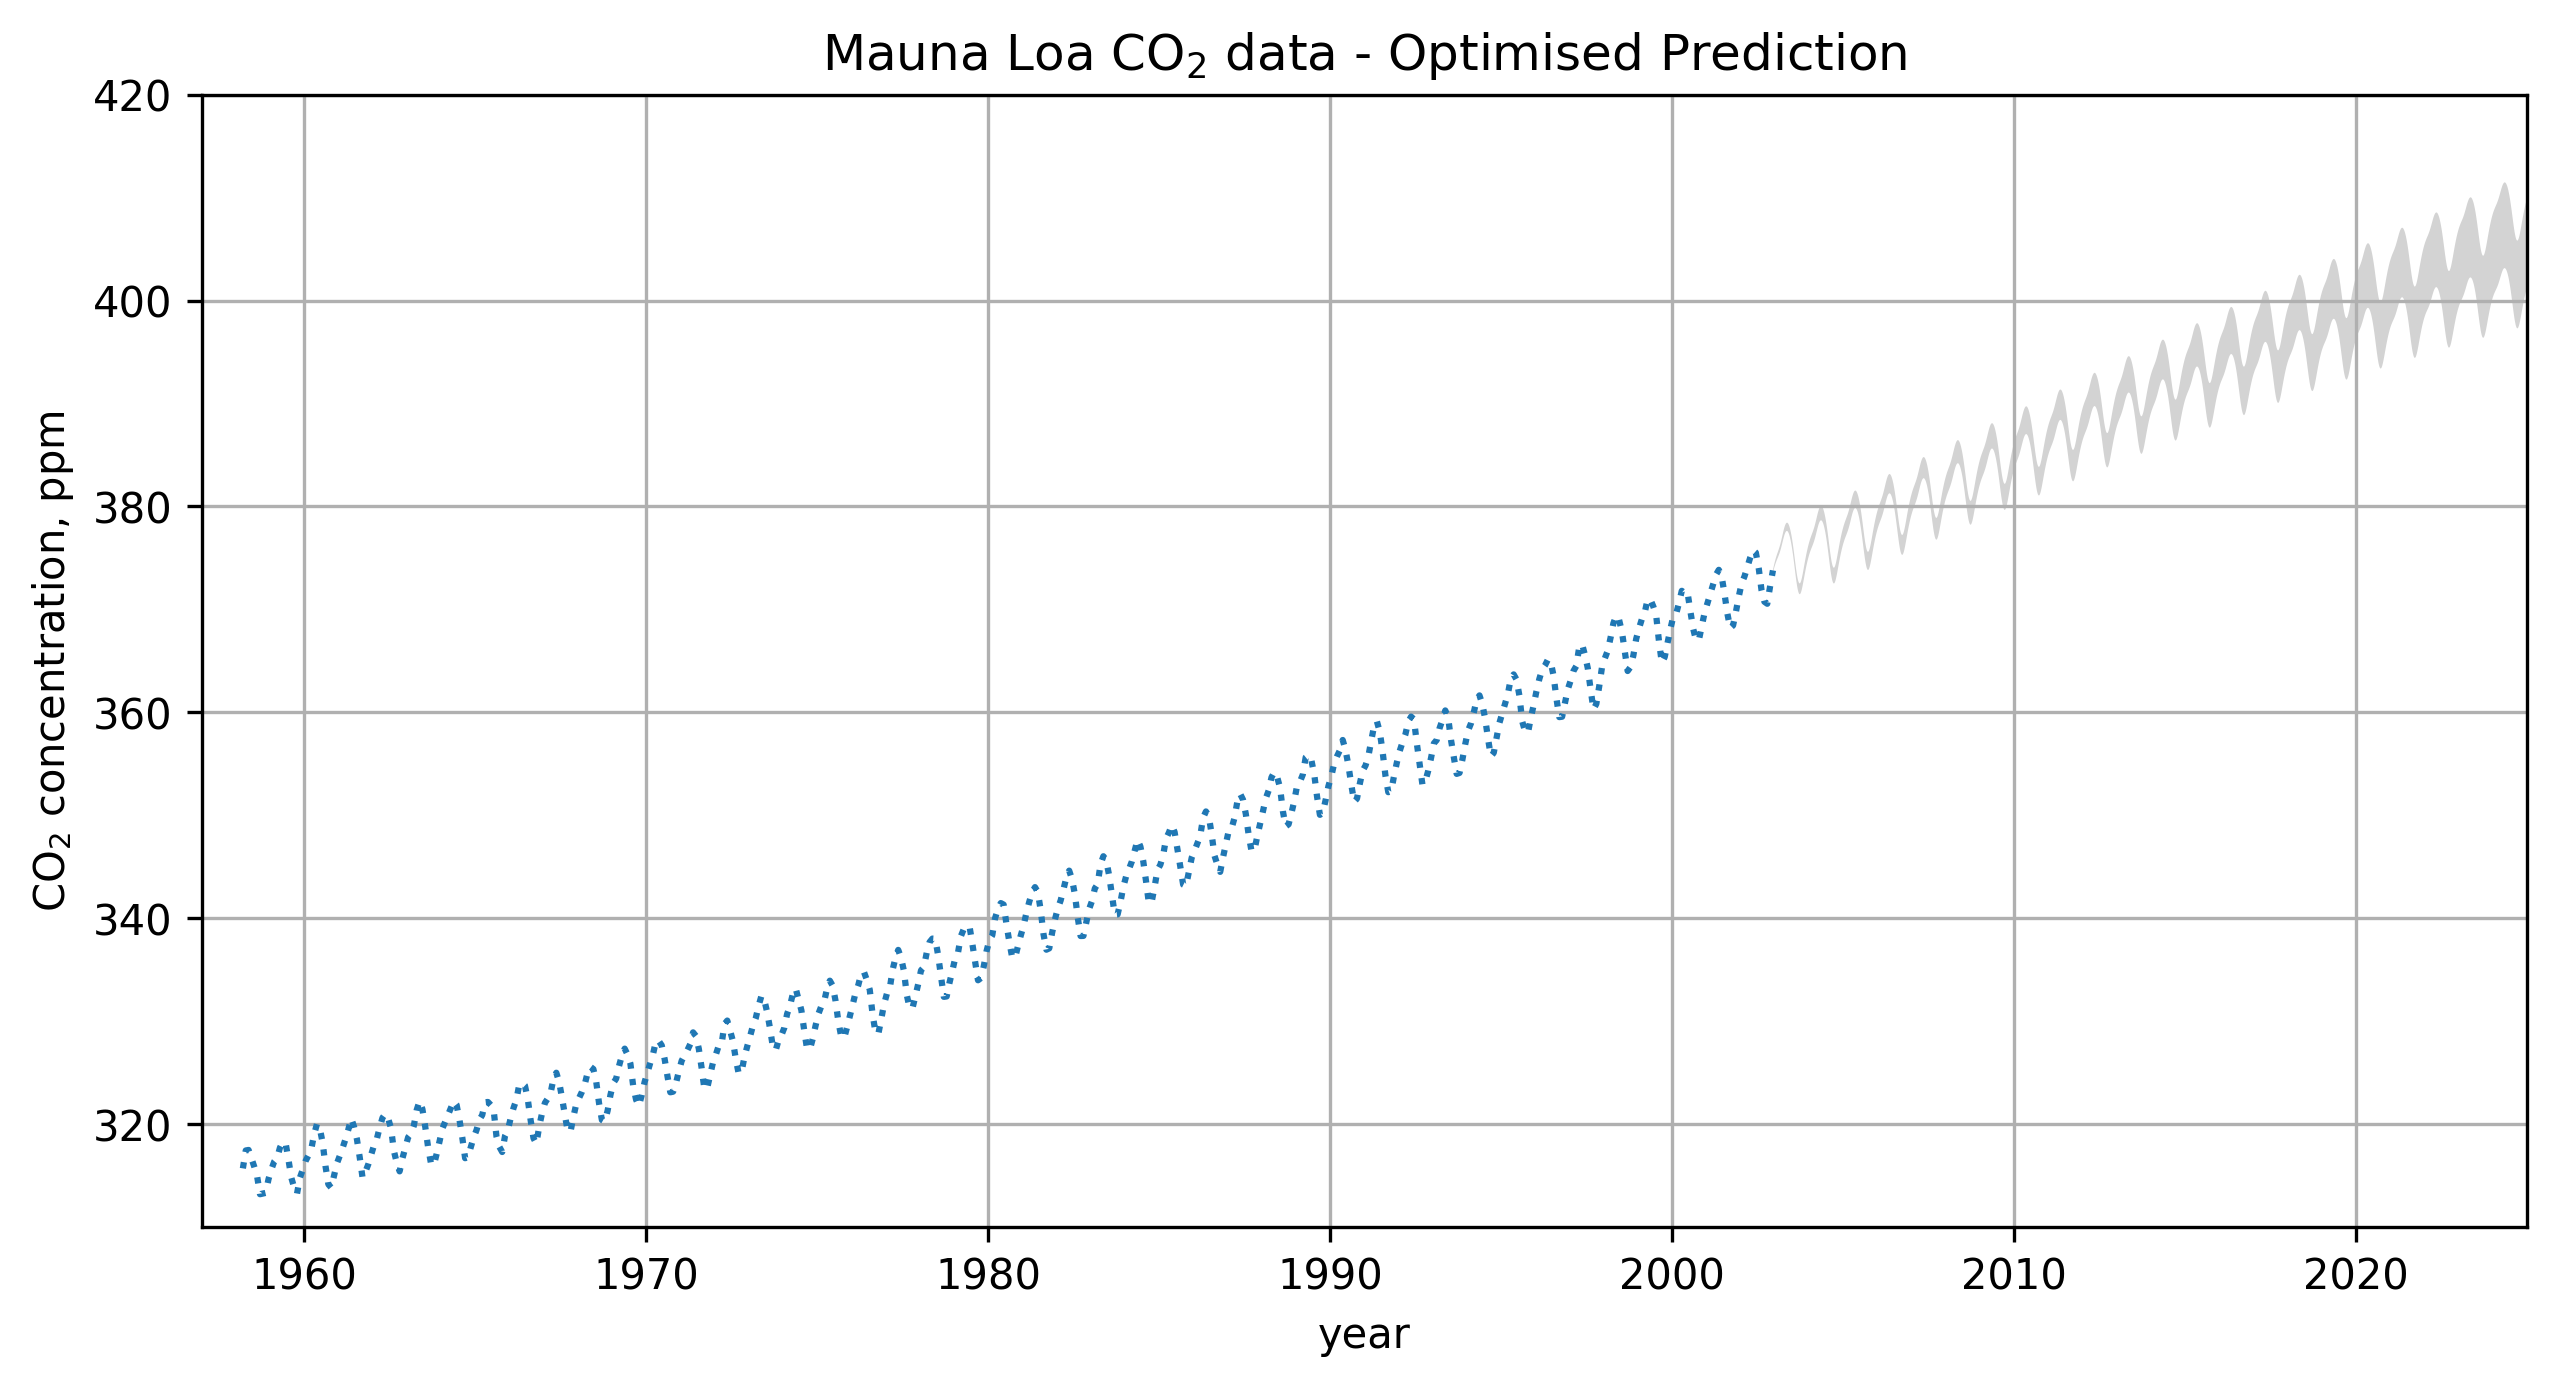

In [19]:
ax = pl.subplot(111)

# plot the original values
pl.plot(t_to_2003,y_to_2003,ls=':') 

# shade in the area inside a one standard deviation bound:
ax.fill_between(x,mu-std,mu+std,facecolor='lightgrey', lw=0, interpolate=True)
pl.title("Predicted")

pl.ylabel(r"CO$_2$ concentration, ppm")
pl.xlabel("year")
pl.title(r"Mauna Loa CO$_2$ data - Optimised Prediction")
pl.axis([1957.,2025.,310.,420.])
pl.grid()

# display the figure:
pl.show()

So how did we do? We can compare our prediction to the actual measurements from 2005 until now...

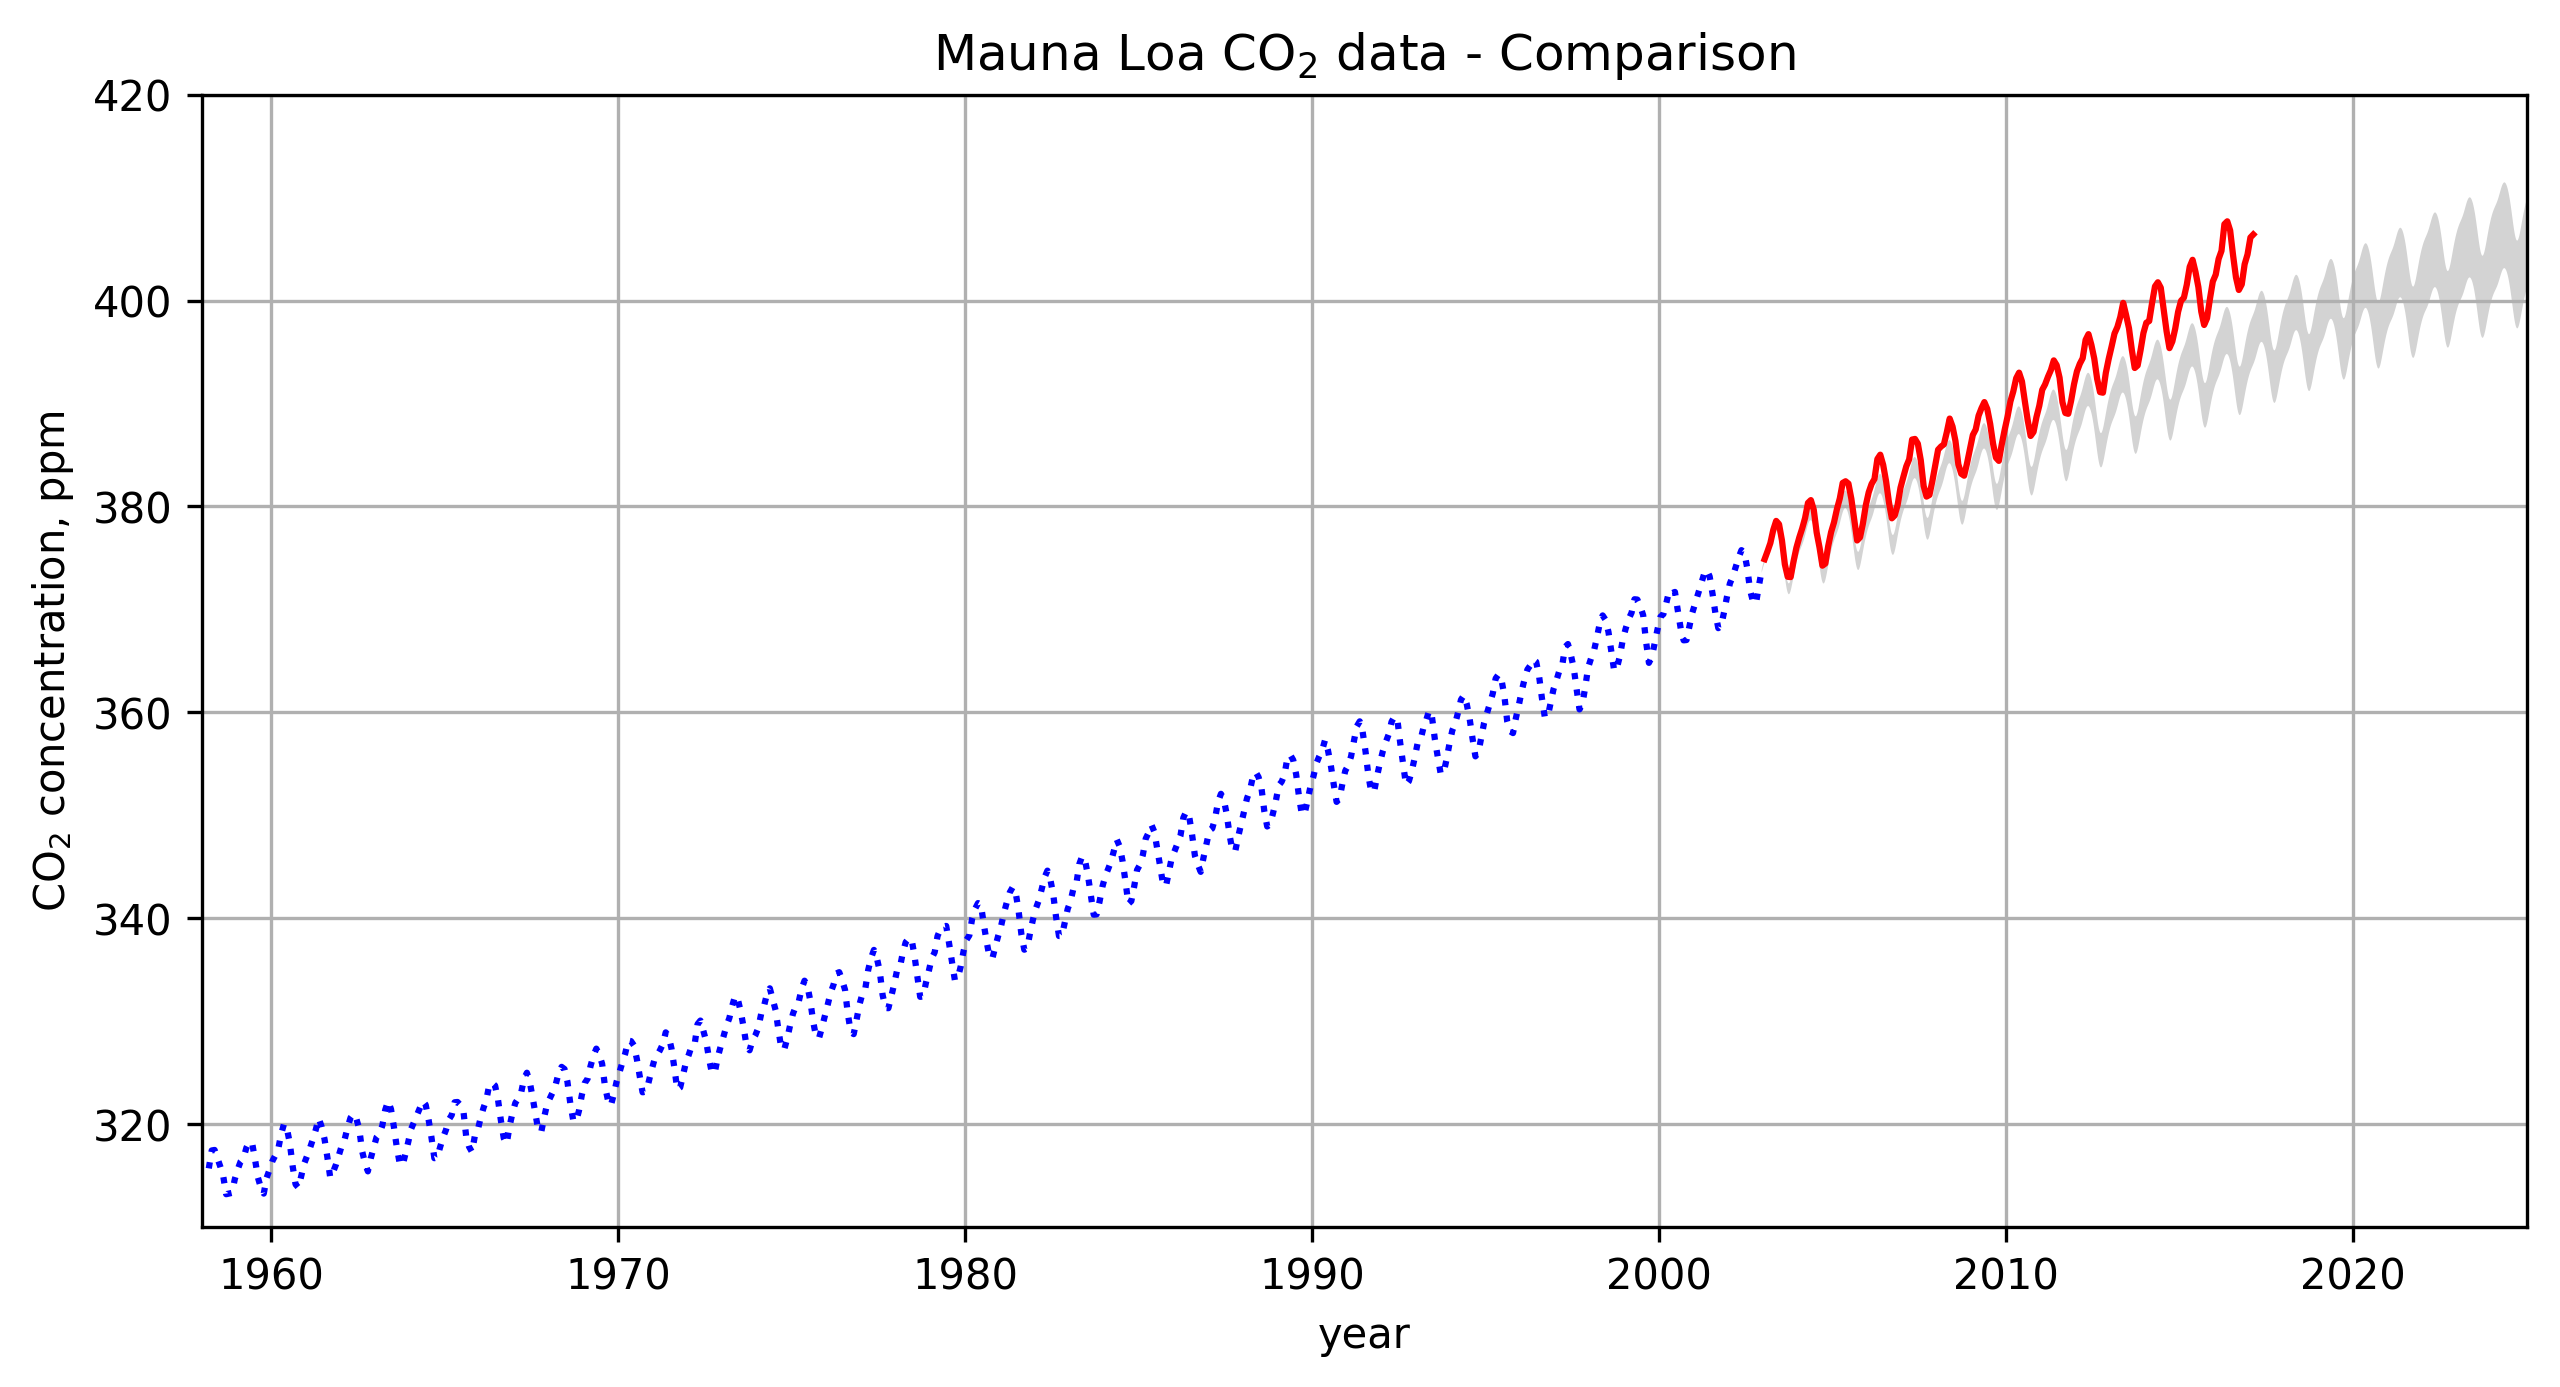

In [20]:
ax = pl.subplot(111)

# plot the training values
pl.plot(t_to_2003,y_to_2003,ls=':',c='b') 

# shade in the area inside a one standard deviation bound:
ax.fill_between(x,mu-std,mu+std,facecolor='lightgrey', lw=0, interpolate=True)

# plot the full dataset
pl.plot(t[np.where(t>2003)],y[np.where(t>2003)],ls='-',c='r') 

pl.ylabel(r"CO$_2$ concentration, ppm")
pl.xlabel("year")
pl.title(r"Mauna Loa CO$_2$ data - Comparison")
pl.axis([1958.,2025.,310.,420.])
pl.grid()

# display the figure:
pl.show()

-- DONE --